# DSC511 Group Project: Hotel Review Sentiment Analysis and Rating Prediction

## Authors

- Maria Tsilidou
- Anastasios Nikodimou
- Ioannis Demetriou

In [ ]:
# Importing libraries

from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("viridis")
# Get or create a SparkSession object
spark = SparkSession.builder.appName("DSC511-GroupProject").master("local[*]").config("spark.driver.memory", "10g").getOrCreate()

## Exploratory Data Analysis

In this section we will load, understand the dimension and schema, and explore our
dataset.

The dataset is obtained from [here](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe).


The csv file contains 17 fields. The description of each field is as below:

- `Hotel_Address`: Address of hotel.
- `Review_Date`: Date when reviewer posted the corresponding review.
- `Average_Score`: Average Score of the hotel, calculated based on the latest comment in the last year.
- `Hotel_Name`: Name of Hotel
- `Reviewer_Nationality`: Nationality of Reviewer
- `Negative_Review`: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
- `Review_Total_Negative_Word_Counts`: Total number of words in the negative review.
- `Positive_Review`: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
- `Review_Total_Positive_Word_Counts`: Total number of words in the positive review.
- `Reviewer_Score`: Score the reviewer has given to the hotel, based on his/her experience
- `Total_Number_of_Reviews_Reviewer_Has_Given`: Number of Reviews the reviewers has given in the past.
- `Total_Number_of_Reviews`: Total number of valid reviews the hotel has.
- `Tags`: Tags reviewer gave the hotel.
- `days_since_review`: Duration between the review date and scrape date.
- `Additional_Number_of_Scoring`: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.
- `lat`: Latitude of the hotel
- `lng`: longtitude of the hotel

Here we took advantage of spark's ability to understand files compressed with gzip
and we added the dataset in a `.csv.gz` form.

In [ ]:
# Loading dataset

# Note: inferSchema=True is "expensive". Consider removing it for performance if needed
# Consider fitting the once deduced `original_schema` while re-running this
original = spark.read.csv('./data/Hotel_Reviews.csv.gz', header=True, inferSchema=True)
original_schema = original.schema

In [1]:
# Getting an idea about the dataset's shape
original_count = original.count()
print(f'Number of observations: {original_count}')
print(f'Number of features: {len(original_schema)}')

Number of observations: 515738
Number of features: 17


### Understanding the dataset

The dataset appears to be the "exploded" join of a hotel, reviewer and review table. In particular,

Hotel:

- `Hotel_Name`: Name of Hotel
- `Hotel_Address`: Address of hotel.
- `lat`: Latitude of the hotel
- `lng`: longtitude of the hotel
- `Average_Score`: Average Score of the hotel, calculated based on the latest comment in the last year.
- `Total_Number_of_Reviews`: Total number of valid reviews the hotel has.

Reviewer:

- `Reviewer_Nationality`: Nationality of Reviewer
- `Total_Number_of_Reviews_Reviewer_Has_Given`: Number of Reviews the reviewers has given in the past.

Review:

- `Review_Date`: Date when reviewer posted the corresponding review.
- `Negative_Review`: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
- `Review_Total_Negative_Word_Counts`: Total number of words in the negative review.
- `Positive_Review`: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
- `Review_Total_Positive_Word_Counts`: Total number of words in the positive review.
- `Reviewer_Score`: Score the reviewer has given to the hotel, based on his/her experience
- `Tags`: Tags reviewer gave the hotel.
- `days_since_review`: Duration between the review date and scrape date.
- `Additional_Number_of_Scoring`: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.

In [2]:
# We visualize the first entries in order to decide our next steps

original.printSchema()
original.select(
    'Hotel_Name', 'Reviewer_Nationality',
    'Review_Date', 'Negative_Review', 'Positive_Review', 'Tags', 'days_since_review'
    ).show(5, truncate=15)

root
 |-- Hotel_Address: string (nullable = true)
 |-- Additional_Number_of_Scoring: integer (nullable = true)
 |-- Review_Date: string (nullable = true)
 |-- Average_Score: double (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)
 |-- Negative_Review: string (nullable = true)
 |-- Review_Total_Negative_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews: integer (nullable = true)
 |-- Positive_Review: string (nullable = true)
 |-- Review_Total_Positive_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews_Reviewer_Has_Given: integer (nullable = true)
 |-- Reviewer_Score: double (nullable = true)
 |-- Tags: string (nullable = true)
 |-- days_since_review: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)

+-----------+--------------------+-----------+---------------+---------------+---------------+-----------------+
| Hotel_Name|Reviewer_Nationality|R

### Cleaning the dataset

We want to check the quality of our dataset. Since we are dealing with reviews,
we want to check if:

- There are duplicate entries
- There are obvious erroneous entries
- There are missing features

In [ ]:
cleaned = original

In [3]:
# Checking for duplicates
cleaned = cleaned.drop_duplicates()

print(f'From our dataset, {cleaned.count()} / {original_count} are distinct')

From our dataset, 515212 / 515738 are distinct


### Type casting the dataset

We now inspect the schema and encoding of our features. We want to cast the data
into a format that will be easier to process.

From the schema and the first few observations, we see that we can benefit
from casting to more python friendly instances, or categorical features that
can be encoded as such.

Some datasets use different string literals to mean missing data. These include
'NA', 'No Review', 'N/A', NONE', 'NULL', 'MISSING', '', 0, etc.

Let's harmonize by replacing such data with `None`

In [4]:
# We notice that lon/lat represented here as decimal degrees should be numeric,
# but they are typed as strings. This could mean that there are some "hard-coded" NAs

cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(~col('lng').rlike(r'[0-9]') | ~col('lat').rlike(r'[0-9]'))\
    .show(5)

# It seems that 'NA' is `None`. Let's update it
cleaned = cleaned\
    .withColumn(
        'lng',
        when(col('lng') == 'NA', lit(None)).otherwise(col('lng'))
    ).withColumn(
        'lat',
        when(col('lat') == 'NA', lit(None)).otherwise(col('lat'))
    )

# Verify
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(~col('lng').rlike(r'[0-9]') | ~col('lat').rlike(r'[0-9]'))\
    .show(5)

+--------------------+---+---+
|       Hotel_Address|lng|lat|
+--------------------+---+---+
|4 rue de la P pin...| NA| NA|
|4 rue de la P pin...| NA| NA|
|4 rue de la P pin...| NA| NA|
|Bail n 4 6 Eixamp...| NA| NA|
|Bail n 4 6 Eixamp...| NA| NA|
+--------------------+---+---+
only showing top 5 rows

+-------------+---+---+
|Hotel_Address|lng|lat|
+-------------+---+---+
+-------------+---+---+



In [ ]:
# According to the dataset, no positive / negative reviews are expressed as 'No Positive' / 'No Negative'
cleaned = cleaned\
    .withColumn(
        'Negative_Review',
        when(col('Negative_Review') == 'No Negative', lit(None)).otherwise(col('Negative_Review'))
    ).withColumn(
        'Positive_Review',
        when(col('Positive_Review') == 'No Positive', lit(None)).otherwise(col('Positive_Review'))
    )

# Verify
cleaned.select('Negative_Review', 'Positive_Review').show()

We notice that some of our features are time related, but are typed as strings.

In particular,

- `Review_Date`
- `days_since_review`

We will cast them to datetime and integers (after we confirm the units) respectively

In [5]:
cleaned = cleaned\
    .withColumn('Review_Date', to_date(col('Review_Date'), format='M/d/yyyy'))

# Let's see if it worked
cleaned\
    .select('Review_Date')\
    .show(5)

+-----------+
|Review_Date|
+-----------+
| 2016-01-03|
| 2015-09-07|
| 2017-06-05|
| 2016-03-01|
| 2016-07-03|
+-----------+
only showing top 5 rows



In [6]:
cleaned\
    .select('days_since_review')\
    .show(5)

# We see that the format is "<days> day(s)"

def parse_days_ago(literal):
    days, unit = literal.split()
    if not days.isdigit():
        raise RuntimeError(f'Unexpected day: {days}')

    if not unit.startswith('day'):
        raise RuntimeError(f'Unexpected time unit: {unit}')

    try:
        return int(days)
    except Exception as e:
        e.args = (f'An error occurred while processing {literal}: {e}',)
        raise


days_ago_udf = udf(parse_days_ago, IntegerType())

cleaned = cleaned\
    .withColumn('days_since_review',
        days_ago_udf(col('days_since_review'))
    )

# Admire our result
cleaned\
    .select('days_since_review')\
    .show(5)

+-----------------+
|days_since_review|
+-----------------+
|          578 day|
|          696 day|
|          59 days|
|          520 day|
|          396 day|
+-----------------+
only showing top 5 rows

+-----------------+
|days_since_review|
+-----------------+
|              578|
|              696|
|               59|
|              520|
|              396|
+-----------------+
only showing top 5 rows



In [ ]:
# Encode location

# TODO: Check if Hotel_Address matches (lng, lat) via reverse geolocation

We saw before that our dataset consists of the join between "Hotel", "Reviewer" and "Review".
It is natural to catagorize the "keys" of these tables where possible. In particular,
the natural categorizations are:

- `Reviewer_Nationality`
- `Hotel_Name`

Let's explore and encode them.

In [7]:
byReviewer = cleaned\
    .groupBy('Reviewer_Nationality')

print(f'There are reviewers with {byReviewer.count().count()} different nationalities')
# TODO: According to wikipedia, there are 193 countries. Are there duplicates?

byReviewer\
    .count()\
    .sort('count', ascending=False)\
    .show(n=10, truncate=False)

nationality_indexer = StringIndexer(inputCol='Reviewer_Nationality', outputCol='Reviewer_Nationality_Encoded')
cleaned = nationality_indexer.fit(cleaned).transform(cleaned)
cleaned.select('Reviewer_Nationality', 'Reviewer_Nationality_Encoded').show(5)

There are reviewers with 227 different nationalities
+--------------------------+------+
|Reviewer_Nationality      |count |
+--------------------------+------+
| United Kingdom           |245110|
| United States of America |35349 |
| Australia                |21648 |
| Ireland                  |14814 |
| United Arab Emirates     |10229 |
| Saudi Arabia             |8940  |
| Netherlands              |8757  |
| Switzerland              |8669  |
| Germany                  |7929  |
| Canada                   |7883  |
+--------------------------+------+
only showing top 10 rows

+--------------------+----------------------------+
|Reviewer_Nationality|Reviewer_Nationality_Encoded|
+--------------------+----------------------------+
|             Israel |                        11.0|
|          Argentina |                        69.0|
|             Sweden |                        23.0|
|     United Kingdom |                         0.0|
|               Oman |                        47.0|
+

We can see that from our dataset, the British, American and Australian tourists
seem to leave the most reviews. This might be because in our original dataset
all reviews are in English, and in these countries English is their native language.

It's worth noting that this selection was either enforced by the review website
or non-Engish reviews where filtered out before we received it, which appears
to introduce a bias toards more affluent countries.

In [8]:
byHotel = cleaned\
    .groupBy('Hotel_Name')

print(f'There are reviews for {byHotel.count().count()} different hotels')
# TODO: Check if there are duplicates with similar name

byHotel\
    .count()\
    .sort('count', ascending=False)\
    .show(n=10, truncate=False)

hotel_indexer = StringIndexer(inputCol='Hotel_Name', outputCol='Hotel_Name_Encoded')

cleaned = hotel_indexer.fit(cleaned).transform(cleaned)
cleaned.select('Hotel_Name', 'Hotel_Name_Encoded').show(5)

There are reviews for 1492 different hotels
+-------------------------------------------------+-----+
|Hotel_Name                                       |count|
+-------------------------------------------------+-----+
|Britannia International Hotel Canary Wharf       |4789 |
|Strand Palace Hotel                              |4256 |
|Park Plaza Westminster Bridge London             |4169 |
|Copthorne Tara Hotel London Kensington           |3577 |
|DoubleTree by Hilton Hotel London Tower of London|3212 |
|Grand Royale London Hyde Park                    |2958 |
|Holiday Inn London Kensington                    |2768 |
|Hilton London Metropole                          |2628 |
|Millennium Gloucester Hotel London               |2565 |
|Intercontinental London The O2                   |2551 |
+-------------------------------------------------+-----+
only showing top 10 rows

+----------------+------------------+
|      Hotel_Name|Hotel_Name_Encoded|
+----------------+------------------+
|   

In [ ]:
# At this point preprocessing has finished we save our data to parquet
cleaned.write.parquet('./data/Hotel_Reviews.parquet')

### Explore Features

Our dataset is quite large, and considering all observations when exploring the
dataset would be computational expensive and time consuming.

To overcome this, we sample from the original dataset.

In [ ]:
# Taking a smaller chunk to make exploration more computational efficient

sample = cleaned.sample(fraction=0.1, withReplacement=False, seed=42)

In [9]:
# FIXME: For compatibility we cast to pandas - this should not be done in the content of big data

sample_pandas = sample.toPandas()
description = sample_pandas[['Additional_Number_of_Scoring', 'Average_Score', 'Reviewer_Score']].describe()

print('[Sample] Numerical features description:')
print(description)

[Sample] Numerical features description:
       Additional_Number_of_Scoring  Average_Score  Reviewer_Score
count                  51663.000000   51663.000000    51663.000000
mean                     495.225848       8.398895        8.400317
std                      498.880731       0.548920        1.634091
min                        1.000000       5.200000        2.500000
25%                      168.000000       8.100000        7.500000
50%                      337.000000       8.400000        8.800000
75%                      641.000000       8.800000        9.600000
max                     2682.000000       9.800000       10.000000


From the statistical summary above we can decide whether our data needs scaling
or not based on mean and std values.

Here mean ranges from 8.4 ('Average_Score') to 496.51 ('Additional_Number_of_Scoring').
This is an indication that scaling will be necessary since we are talking about a big
enough difference in the scale of our data.

#### Checking for skewness in the target variable

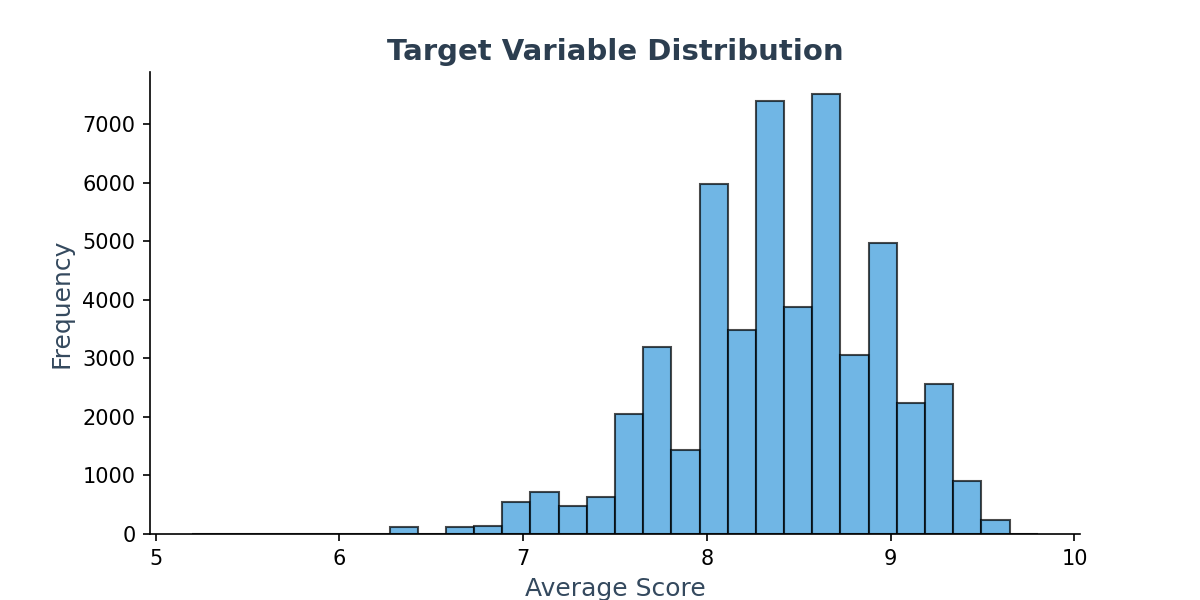

In [10]:
# Creating the histogram

plt.figure(figsize=(8, 4))  # Setting figure size
plt.hist(sample_pandas['Average_Score'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)

plt.title('Target Variable Distribution', fontsize=14, fontweight='bold', color='#2c3e50')
plt.xlabel('Average Score', fontsize=12, color='#34495e')
plt.ylabel('Frequency', fontsize=12, color='#34495e')

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

From the statistical summary we saw that the mean of the 'Average_Score' is close to 8.4
and from the plot we can see that our target variable is slightly skewed to the left.

This could potentially be due to the presence of an outlier around the value 6.3 - 6.4.
To be more specific about the skewness we can use .skew().

In [11]:
sample_pandas['Average_Score'].skew()

np.float64(-0.5569988479609004)

#### Checking for linear correlation between numeric features and the target variable

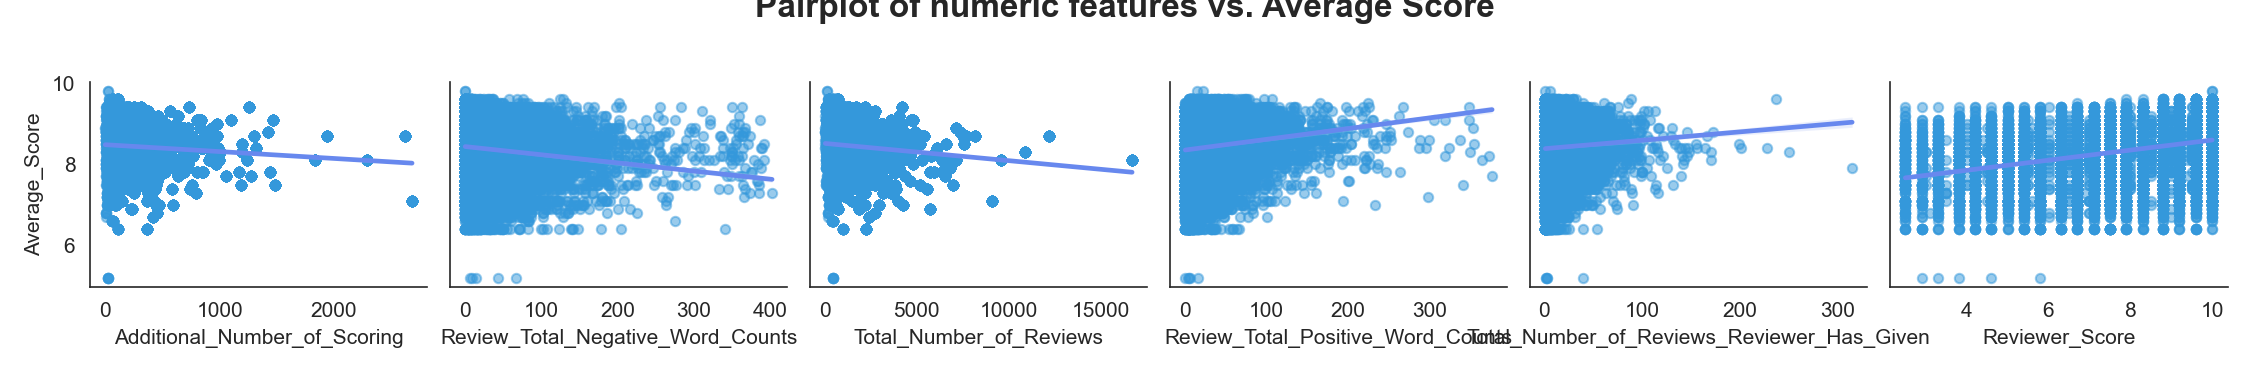

In [12]:
# Setting Seaborn style for a cleaner look

sns.set_style("white")
sns.set_palette("coolwarm")

# Creating the pairplot
g = sns.pairplot(
    sample_pandas,
    x_vars=[
        'Additional_Number_of_Scoring', 'Review_Total_Negative_Word_Counts',
        'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts',
        'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score'
    ],
    y_vars="Average_Score",
    kind="reg",  # Regression line
    plot_kws={'scatter_kws': {'alpha': 0.5, 's': 20, 'color': '#3498db'}},  # Customize scatter points
    height=2.5,  # Adjust individual plot height
)

# Improve spacing
plt.suptitle("Pairplot of numeric features vs. Average Score", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Show the plot
plt.show()

We plotted some numeric features fitted using linear regression against the target variable `Average_Score`.

We notice, as expected, that individual reviewer review `Reviewer_Score`, and the total
"positive" words used in the review `Review_Total_Positive_Word_Counts` is positively correlated
with `Average_Score`. Perphaps more suprising, the more reviews a user has given `Total_Number_of_Reviews_Reviewer_Has_Given`
is also positively correlated with the venue's average score.

On the other side, we again expected that `Review_Total_Negative_Word_Counts` negatively
correlates to a venue's average score. Perphaps more suprising, the more reviews a venue has
`Total_Number_of_Reviews`, the smaller its average score

#### Visualizing correlation using a heatmap

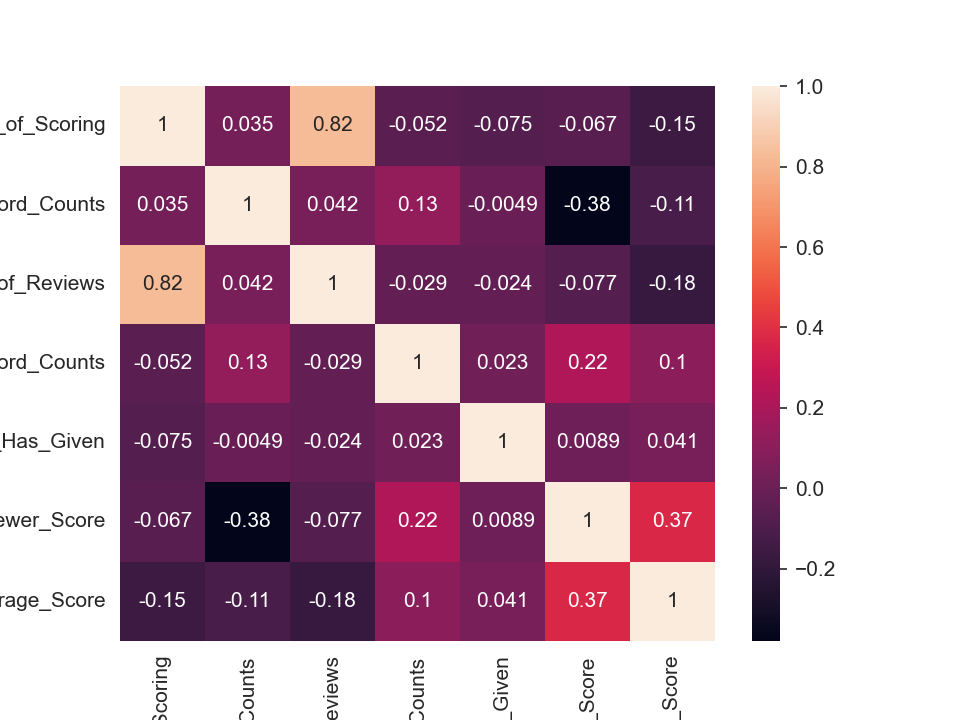

<Axes: >

In [13]:
# An alternative way to visualize linear correlation

fig, ax = plt.subplots()

num_features = sample_pandas[[
        'Additional_Number_of_Scoring', 'Review_Total_Negative_Word_Counts',
        'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts',
        'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Average_Score'
    ]]
sns.heatmap(num_features.corr(method='pearson'), annot=True)

From the heatmap we can see that `Additional_Number_of_Scoring` and `Total_Number_of_Reviews`
are highly linearly correlated since the correlation coefficient is equal to 0.82 (very close to 1).

We can also see a weak linear correlation between `Additional_Number_of_Scoring`
and ΄lat΄ where the correlation coefficient is equal to 0.34.

As already studied in the previous pairplots `Average_Score` and `Reviewer_Score`
are linearly correlated even though their correlation is also pretty weak
(correlation coefficient equals to 0.37).